In [121]:
import math

import snntorch as snn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from aes_commons import *
import random

In [122]:
config = {
    # Meta
    "no_epochs": 10,
    "batch_size" : 100000,
    # SNN config
    "num_steps": 1,
    "beta": 0.95,
    
    # Network dimentions
    "num_inputs": 128,
    "num_spiking1": 128,
    "num_spiking2": 128,
    "num_hidden_out": 128,
    "num_outputs": 128
}

In [123]:


def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

@dataclass
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_config():        
        return CryptoDataset(no_bytes=config["num_inputs"]//8,batch_size = config["batch_size"])
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_sub_byte(self):
        
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = mix_columns(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration
    
    

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [124]:
from snntorch import spikegen

# spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [125]:
class Model(nn.Module):
    def __init__(self):
        super().__init__();
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_outputs"])
    
    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += spikes2
        
        out = self.fc3(spike_sum)
        
        # Maybe another dense layer
        
        return out


In [126]:
net = Model()

In [127]:
from torch.utils.data import DataLoader
train_loader = CryptoDataset.from_config()
train_loader

CryptoDataset(no_bytes=16, batch_size=100000, n=0)

In [128]:
import snntorch.spikeplot as splt

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
spike_data.size()

torch.Size([1, 128])

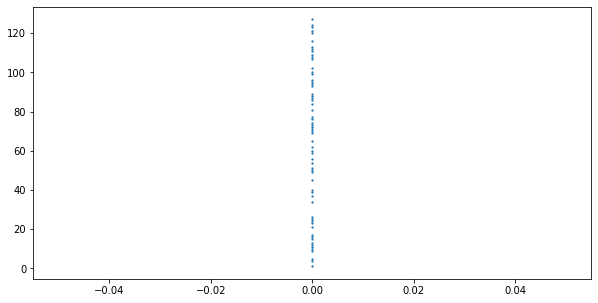

In [129]:
spike_data = spike_data[:]
spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_plot, ax, s=1.5)

In [130]:
loss_func = nn.MSELoss() # Idk
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_hist = []

In [131]:
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in enumerate(train_loader):
        net.train()
        
        # forward
        output = net(x)
        loss = loss_func(output, y)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append(loss.item())

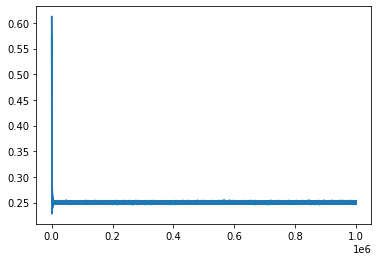

In [132]:
plt.plot(loss_hist)

In [137]:
def diff(output:List[float],label:List[float]):

        same = 0.0
        for o, l in zip(output,label):
            same += abs(o - l)

        return same / len(output)
def radical(output:List[float])->List[int]:
    solution = np.zeros(len(output))
    for id, o in enumerate(output):
        if o >= 0.5:
            solution[id] = 1
        else:
            solution[id] = 0
    return solution

global_difference = 0
net.eval()
with torch.no_grad():
    for index in range(10):
        inputs, labels = train_loader.next_sub_byte() # torch.tensor([float(i)]) / 100, torch.tensor([float(i+10)]) / 100
        outputs = net(inputs)

        print(f"    output: {outputs.detach().numpy()}\nrad output: {radical(outputs.detach().numpy())}\n     labels: {radical(labels)}")
    


    output: [0.48751572 0.5034663  0.5157932  0.5176997  0.5008864  0.50126183
 0.48557192 0.49512383 0.499977   0.4998512  0.49099678 0.50653255
 0.5205765  0.5087731  0.49183303 0.49338132 0.4952267  0.5079662
 0.47319168 0.49238405 0.4779486  0.4943228  0.51486856 0.49120367
 0.49489436 0.49199587 0.49770096 0.48714966 0.50179034 0.5033951
 0.5100289  0.49880522 0.50779825 0.49366772 0.5116118  0.50248235
 0.50042254 0.5029278  0.49758875 0.49819162 0.50939196 0.512046
 0.5049743  0.5246529  0.5097925  0.5065173  0.50206095 0.4792766
 0.5060841  0.5025823  0.5061633  0.48903894 0.49269757 0.5028648
 0.4937952  0.49568272 0.51971024 0.4778083  0.5017931  0.52415156
 0.48643178 0.5105267  0.48039535 0.514869   0.49042565 0.49070135
 0.5166881  0.5162278  0.50267714 0.5205514  0.5329444  0.5121941
 0.5064275  0.4799664  0.4995077  0.4912384  0.4928809  0.50565404
 0.48045522 0.47930762 0.50418353 0.4995076  0.49596035 0.48549798
 0.5069944  0.5170609  0.51446784 0.5052806  0.50782907 0

In [143]:
# def loss_func(input, output):
#     output = radical(output)
#     input = radical(input)
#     same = 0
#     for i, o in zip(input, output):
#         if i == o:
#             same += 1
#         else:
#             break
#     return torch.tensor(1 - (same / len(input)), requires_grad=True)

def loss_func(input, output):
    output = radical(output.detach().numpy())
    label = radical(label.detach().numpy())
    same = 0
    for i, o in zip(input, output):
        if i == o:
            same += 1
        else:
            break
    return same 

def radical_diff(output:List[float],label:List[float]):
    output = radical(output)
    label = radical(label)
    difference = 0
    for o,l in zip(output,label):
        if o != l:
            difference+=1
    return difference

global_diff = 0
print(output.shape)
for _ in range(10_00):
        input, label = train_loader.next_sub_byte()
        output = net(input)
        global_diff += loss_func(label,output)
        
print(global_diff /10_00)

torch.Size([128])


UnboundLocalError: local variable 'label' referenced before assignment

In [135]:
net(torch.tensor([1], dtype=torch.float32))

RuntimeError: size mismatch, got 128, 128x128,1